In [3]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
import shutil

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         
from transformers import pipeline                                    
from transformers import DataCollatorForSeq2Seq                         
import torch                                                              
import evaluate                                                           


# Other NLP libraries
from textblob import TextBlob                                             
from sklearn.feature_extraction.text import TfidfVectorizer               
import re                                                                 
import nltk                                                               
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Huggingface
from evaluate import load
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline # model

In [6]:
import pandas as pd
import numpy as np
import nltk
import re
from datasets import Dataset

# Load datasets
train_df = pd.read_csv('samsum_train.csv')
test_df = pd.read_csv('samsum_test.csv')
val_df = pd.read_csv('samsum_validation.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB
None
              id                                           dialogue  \
count      14732                                              14731   
unique     14732                                              14264   
top     13729017  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                                                  summary  
count                                               14732  
unique                                              14730  
top     Seth's pet Oreo that he got when he was 10 is ...  
freq                                                    2  

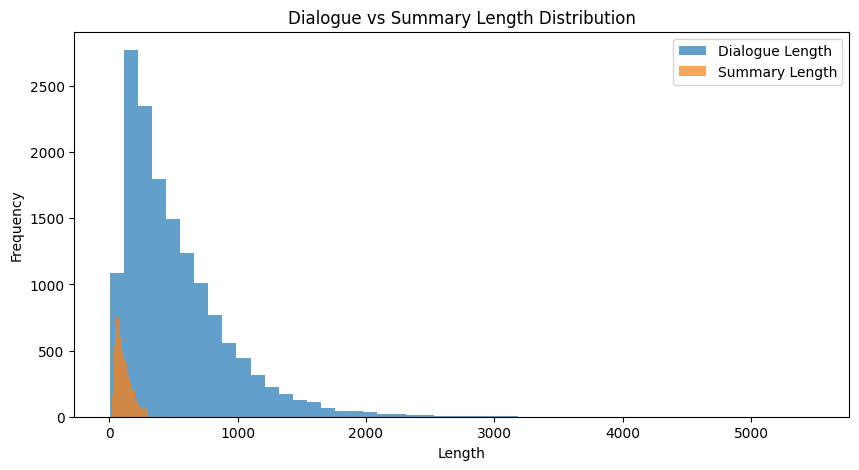

In [7]:
import matplotlib.pyplot as plt

# Basic information about the dataset
print(train_df.info())
print(train_df.describe())

# Visualize dialogue and summary lengths

train_df['dialogue_len'] = train_df['dialogue'].astype(str).apply(len)
train_df['summary_len'] = train_df['summary'].astype(str).apply(len)

plt.figure(figsize=(10,5))
plt.hist(train_df['dialogue_len'], bins=50, alpha=0.7, label='Dialogue Length')
plt.hist(train_df['summary_len'], bins=50, alpha=0.7, label='Summary Length')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Dialogue vs Summary Length Distribution')
plt.show()

In [8]:
train_df.describe()

,dialogue_len,summary_len
count,14732.000000,14732.000000
mean,511.183818,110.134673
std,402.621178,60.892471
min,3.000000,3.000000
25%,216.000000,63.000000
50%,401.000000,96.000000
75%,694.000000,144.000000
max,5492.000000,300.000000


In [9]:
train_df.isnull().sum()

,0
id,0
dialogue,1
summary,0
dialogue_len,0
summary_len,0


In [10]:
#drop null values
train_df.dropna(inplace=True)

In [11]:
# Clean tags and empty dialogues
def clean_tags(text):
    clean = re.compile('<.*?>')
    
    # Replacing tags with an empty string
    clean = re.sub(clean, '', text) 
    
    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])
    return clean

# Apply cleaning function to the dataframes
def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(clean_tags)
    return df

# Clean train, test, and validation datasets
train_df = clean_df(train_df, ['dialogue', 'summary'])
test_df = clean_df(test_df, ['dialogue', 'summary'])
val_df = clean_df(val_df, ['dialogue', 'summary'])

In [12]:
# Convert Pandas dataframes to Hugging Face datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)
val_ds = Dataset.from_pandas(val_df)

In [13]:
#Load BART Model and Tokenizer

from transformers import BartTokenizer, BartForConditionalGeneration

# Define the checkpoint
checkpoint = 'facebook/bart-large-cnn'

# Load the tokenizer and the model
tokenizer = BartTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)

#model architecture
print(model)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [14]:
#pre process the data using bart

def preprocess_function(examples):
    # Tokenize input dialogues
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Tokenize targets (summaries)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=['id', 'dialogue', 'summary','summary_len','__index_level_0__','dialogue_len'])
tokenized_test = test_ds.map(preprocess_function, batched=True, remove_columns=['id', 'dialogue', 'summary'])
tokenized_val = val_ds.map(preprocess_function, batched=True, remove_columns=['id', 'dialogue', 'summary'])

# Print the tokenized datasets
print('Preprocessed Training Dataset:\n', tokenized_train)
print('\nPreprocessed Test Dataset:\n', tokenized_test)
print('\nPreprocessed Validation Dataset:\n', tokenized_val)


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Preprocessed Training Dataset:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 14731
})

Preprocessed Test Dataset:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 819
})

Preprocessed Validation Dataset:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 818
})


In [15]:
from transformers import DataCollatorForSeq2Seq

# Define the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [16]:
#ROUGE metrics for model evaluation

# Load ROUGE metric
rouge_metric = load("rouge")

# Define a function to compute the evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels

    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]


    # Computing rouge score
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value * 100 for key, value in result.items()} # Extracting some results

    # Add mean-generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


In [17]:
from transformers import Seq2SeqTrainingArguments

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='bart_samsum',
    evaluation_strategy="epoch",
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=42,  # Random seed
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)


In [18]:
from transformers import Seq2SeqTrainer

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.357900,1.379575,41.196800,21.266600,31.928500,38.541300,60.184600
2,0.816100,1.465839,41.602600,20.979200,32.090700,38.542600,60.035500
3,0.680400,1.545516,42.211900,21.090500,32.321500,38.996000,59.885100


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=7364, training_loss=0.9870296376739618, metrics={'train_runtime': 5405.289, 'train_samples_per_second': 10.901, 'train_steps_per_second': 1.362, 'total_flos': 3.4901139197116416e+16, 'train_loss': 0.9870296376739618, 'epoch': 3.9989139288623403})

In [19]:
# Evaluate the model
eval_results = trainer.evaluate(tokenized_val)

# Print evaluation results
print("Evaluation Results:", eval_results)


Evaluation Results: {'eval_loss': 1.3795750141143799, 'eval_rouge1': 41.1968, 'eval_rouge2': 21.2666, 'eval_rougeL': 31.9285, 'eval_rougeLsum': 38.5413, 'eval_gen_len': 60.1846, 'eval_runtime': 379.3304, 'eval_samples_per_second': 2.156, 'eval_steps_per_second': 0.54, 'epoch': 3.9989139288623403}


In [20]:
for k,v in eval_results.items():
    print(f"{k:{30}}{round(v,3):{20}}")

eval_loss                                     1.38
eval_rouge1                                 41.197
eval_rouge2                                 21.267
eval_rougeL                                 31.928
eval_rougeLsum                              38.541
eval_gen_len                                60.185
eval_runtime                                379.33
eval_samples_per_second                      2.156
eval_steps_per_second                         0.54
epoch                                        3.999


In [37]:
# Saving model to a custom directory
directory = "finetuned_summarizer"
trainer.save_model(directory)

# Saving model tokenizer
tokenizer.save_pretrained(directory)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('finetuned_summarizer/tokenizer_config.json',
 'finetuned_summarizer/special_tokens_map.json',
 'finetuned_summarizer/vocab.json',
 'finetuned_summarizer/merges.txt',
 'finetuned_summarizer/added_tokens.json')

In [38]:
import shutil

# Zip the model directory
shutil.make_archive('finetuned_summarizer', 'zip', './finetuned_summarizer')


'/finetuned_summarizer.zip'

In [39]:
from google.colab import files

# Download the zipped model
files.download('finetuned_summarizer.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
import shutil
shutil.copytree('finetuned_summarizer', '/content/drive/MyDrive/finetuned_summarizer')

'/content/drive/MyDrive/finetuned_summarizer'

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
